In [1]:
import logging

import numpy as np
import matplotlib.pyplot as plt

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

In [20]:
import jax
import pprint

pprint.pprint(jax.devices())

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=2, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=3, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=4, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=5, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=6, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=7, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=8, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=9, process_index=0, slice_index=0)]


In [2]:
from replay_trajectory_classification.sorted_spikes_simulation import (
    make_simulated_run_data,
)

MM_TO_INCHES = 1.0 / 25.4
TWO_COLUMN = 178.0 * MM_TO_INCHES
GOLDEN_RATIO = (np.sqrt(5) - 1.0) / 2.0

(
    time,
    linear_distance,
    sampling_frequency,
    spikes,
    place_fields,
) = make_simulated_run_data()

INFO:numexpr.utils:Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/home/edeno/miniconda3/envs/non_local_detector_gpu/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from replay_trajectory_classification import (
    SortedSpikesClassifier,
    Environment,
    RandomWalk,
    Uniform,
    estimate_movement_var,
)


movement_var = estimate_movement_var(linear_distance, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [
    [RandomWalk(movement_var=movement_var * 120), Uniform()],
    [Uniform(), Uniform()],
]

classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    sorted_spikes_algorithm="spiking_likelihood_glm",
    sorted_spikes_algorithm_params={"knot_spacing": 10},
)
classifier.fit(linear_distance, spikes)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting continuous state transition...
INFO:replay_trajectory_classification.classifier:Fitting discrete state transition
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-v_frli44', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/worker-6w2undrp', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/worker-doj1nwy_', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/worker-8kpp74tz', purging
INFO:distributed.diskutils:F

SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='',
                                                                movement_var=33.31009971953083,
                                                                movement_mean=0.0,
                                                                use_diffusion=False),
                                                     Uniform(environment_name='',
                                                             environment2_name=None)],
                                                    [Uniform(environment_name='',
                                                             environment2_name=None),
                                                     Uniform(environment_name='',
                                                             environment2_name=None)]],
                       discrete_transition_type=DiagonalDis...
                                                 fill_holes=False,
                                                 dilate=False,
                                                 bin_count_threshold=0),),
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
                       observation_models=(ObservationModel(environment_name='',
                                                            encoding_group=0),
                                           ObservationModel(environment_name='',
                                                            encoding_group=0)),
                       sorted_spikes_algorithm='spiking_likelihood_glm',
                       sorted_spikes_algorithm_params={'knot_spacing': 10})

In [4]:
from replay_trajectory_classification.sorted_spikes_simulation import (
    make_fragmented_continuous_fragmented_replay,
)

replay_time, test_spikes = make_fragmented_continuous_fragmented_replay()

state_names = ["Continuous", "Fragmented"]
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
/home/edeno/miniconda3/envs/non_local_detector_gpu/lib/python3.10/site-packages/replay_trajectory_classification/core.py:205: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'F', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  discrete_state_transition[state_k, state_k_1]


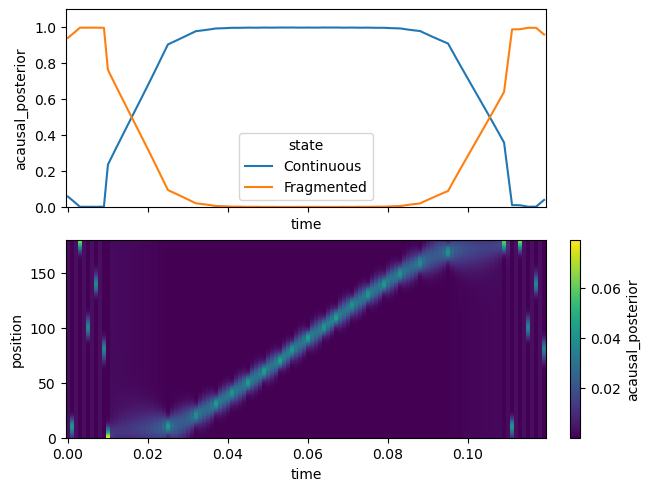

In [5]:
fig, axes = plt.subplots(2, 1, sharex=True, constrained_layout=True)
results.acausal_posterior.sum("position").plot(x="time", hue="state", ax=axes[0])
axes[0].set_ylim((0, 1.1))
results.acausal_posterior.sum("state").plot(x="time", y="position", ax=axes[1])

In [6]:
from non_local_detector import ContFragSortedSpikesClassifier

classifier2 = ContFragSortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    sorted_spikes_algorithm="sorted_spikes_glm_jax",
    sorted_spikes_algorithm_params={"emission_knot_spacing": 10, "l2_penalty": 1e-7},
).fit(linear_distance, spikes)
results2 = classifier2.predict(linear_distance, test_spikes, time=replay_time)

INFO:non_local_detector.models.generic:Fitting initial conditions...
INFO:non_local_detector.models.generic:Fitting discrete state transition
INFO:non_local_detector.models.generic:Fitting continuous state transition...
INFO:non_local_detector.models.generic:Fitting place fields...
2023-06-24 09:26:43.802937: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 0 and 9; status: INTERNAL: failed to enable peer access from 0x7f1930624a00 to 0x7f1950627450: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2023-06-24 09:26:43.811679: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 1 and 9; status: INTERNAL: failed to enable peer access from 0x7f1938638c50 to 0x7f1950627450: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2023-06-24 09:26:43.818934: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 2 and 9; status: INTERNAL: failed to enable peer access 

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

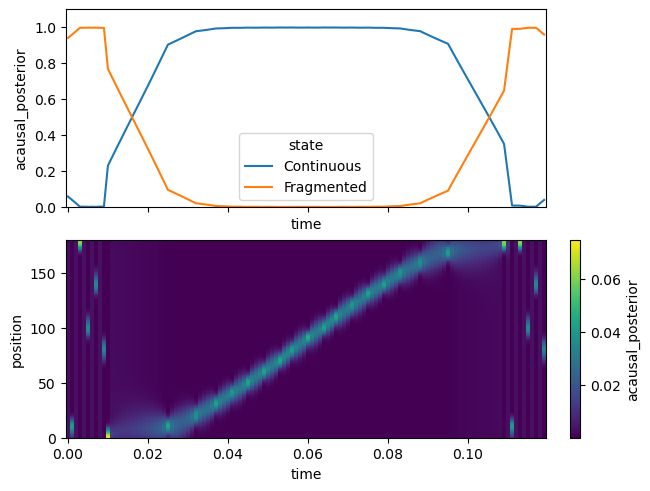

In [7]:
fig, axes = plt.subplots(2, 1, sharex=True, constrained_layout=True)
results2.acausal_posterior.unstack("state_bins").sum("position").plot(
    x="time", hue="state", ax=axes[0]
)
axes[0].set_ylim((0, 1.1))
results2.acausal_posterior.unstack("state_bins").sum("state").plot(
    x="time", y="position", ax=axes[1]
)

In [8]:
np.allclose(classifier.initial_conditions_.ravel(), classifier2.initial_conditions_)

True

In [9]:
for from_state in range(2):
    for to_state in range(2):
        print(
            np.allclose(
                classifier.continuous_state_transition_[from_state, to_state],
                classifier2.continuous_state_transitions_[
                    np.ix_(
                        classifier2.state_ind_ == from_state,
                        classifier2.state_ind_ == to_state,
                    )
                ],
            )
        )

True
True
True
True


In [10]:
np.allclose(
    classifier.discrete_state_transition_, classifier2.discrete_state_transitions_
)

True

In [11]:
norm_likelihood = np.exp(
    classifier2.log_likelihood_ - classifier2.log_likelihood_.max(axis=1, keepdims=True)
)
norm_likelihood

array([[9.9883527e-01, 9.9879426e-01, 9.9870872e-01, ..., 9.9915099e-01,
        9.9958336e-01, 1.0000000e+00],
       [2.7315220e-01, 3.0273288e-01, 3.3523354e-01, ..., 1.7895368e-04,
        1.8616366e-04, 1.9376760e-04],
       [9.9883527e-01, 9.9879426e-01, 9.9870872e-01, ..., 9.9915099e-01,
        9.9958336e-01, 1.0000000e+00],
       ...,
       [2.3052888e-04, 2.2582957e-04, 2.2127817e-04, ..., 1.8761819e-04,
        2.1014108e-04, 2.3578244e-04],
       [9.9883527e-01, 9.9879426e-01, 9.9870872e-01, ..., 9.9915099e-01,
        9.9958336e-01, 1.0000000e+00],
       [4.0797700e-04, 4.0085596e-04, 3.9393996e-04, ..., 3.9526270e-04,
        4.0182046e-04, 4.0857229e-04]], dtype=float32)

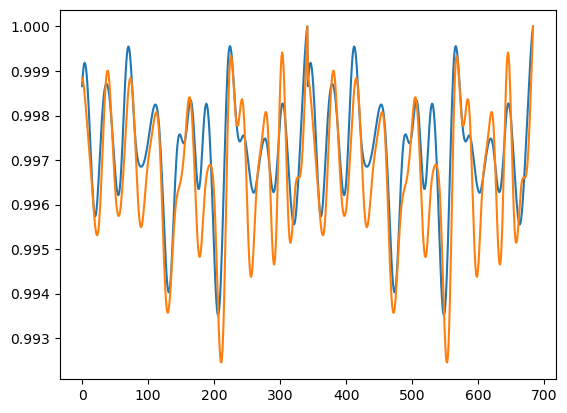

In [12]:
time_ind = 0

plt.plot(
    np.concatenate(
        (
            results.likelihood.sel(state="Continuous").isel(time=time_ind).values,
            results.likelihood.sel(state="Fragmented").isel(time=time_ind).values,
        )
    )
)
plt.plot(norm_likelihood[time_ind])

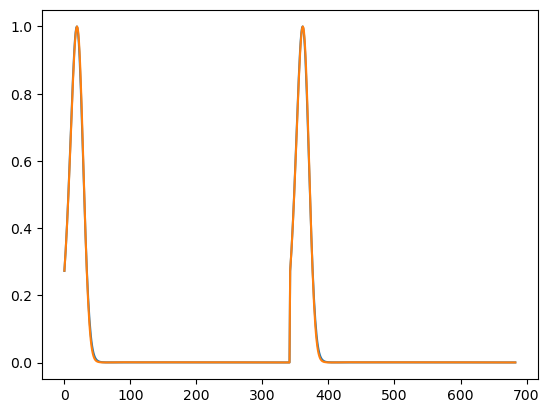

In [13]:
time_ind = 1

plt.plot(
    np.concatenate(
        (
            results.likelihood.sel(state="Continuous").isel(time=time_ind).values,
            results.likelihood.sel(state="Fragmented").isel(time=time_ind).values,
        )
    )
)
plt.plot(norm_likelihood[time_ind])

In [14]:
from non_local_detector import ContFragSortedSpikesClassifier

classifier3 = ContFragSortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    sorted_spikes_algorithm="sorted_spikes_kde_jax",
    sorted_spikes_algorithm_params={"position_std": 5.0},
).fit(linear_distance, spikes)
results3 = classifier3.predict(linear_distance, test_spikes, time=replay_time)

INFO:non_local_detector.models.generic:Fitting initial conditions...
INFO:non_local_detector.models.generic:Fitting discrete state transition
INFO:non_local_detector.models.generic:Fitting continuous state transition...
INFO:non_local_detector.models.generic:Fitting place fields...


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [15]:
norm_likelihood = np.exp(
    classifier3.log_likelihood_ - classifier3.log_likelihood_.max(axis=1, keepdims=True)
)
norm_likelihood

array([[9.9959844e-01, 9.9955601e-01, 9.9950862e-01, ..., 9.9980217e-01,
        9.9990302e-01, 1.0000000e+00],
       [6.1608416e-01, 6.3247555e-01, 6.5002888e-01, ..., 8.5733727e-14,
        8.5742550e-14, 8.5750729e-14],
       [9.9959844e-01, 9.9955601e-01, 9.9950862e-01, ..., 9.9980217e-01,
        9.9990302e-01, 1.0000000e+00],
       ...,
       [8.8749253e-14, 8.8745532e-14, 8.8741128e-14, ..., 6.9842640e-06,
        4.9341324e-06, 3.4758100e-06],
       [9.9959844e-01, 9.9955601e-01, 9.9950862e-01, ..., 9.9980217e-01,
        9.9990302e-01, 1.0000000e+00],
       [8.2926084e-14, 8.2922594e-14, 8.2918495e-14, ..., 8.2942849e-14,
        8.2951393e-14, 8.2959301e-14]], dtype=float32)

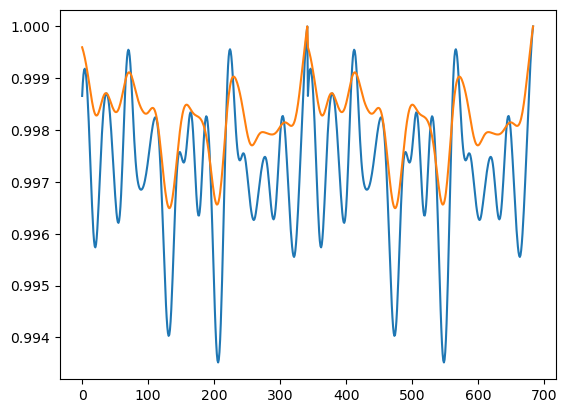

In [16]:
time_ind = 0

plt.plot(
    np.concatenate(
        (
            results.likelihood.sel(state="Continuous").isel(time=time_ind).values,
            results.likelihood.sel(state="Fragmented").isel(time=time_ind).values,
        )
    )
)
plt.plot(norm_likelihood[time_ind])

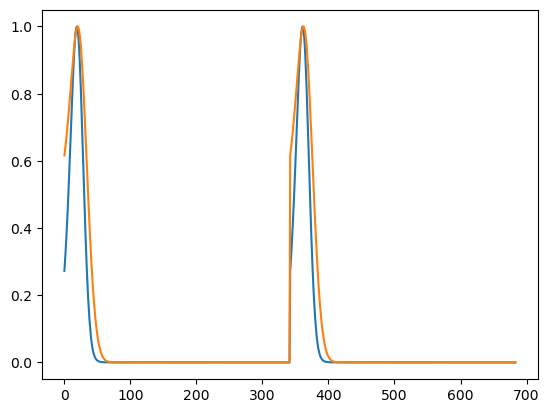

In [17]:
time_ind = 1

plt.plot(
    np.concatenate(
        (
            results.likelihood.sel(state="Continuous").isel(time=time_ind).values,
            results.likelihood.sel(state="Fragmented").isel(time=time_ind).values,
        )
    )
)
plt.plot(norm_likelihood[time_ind])

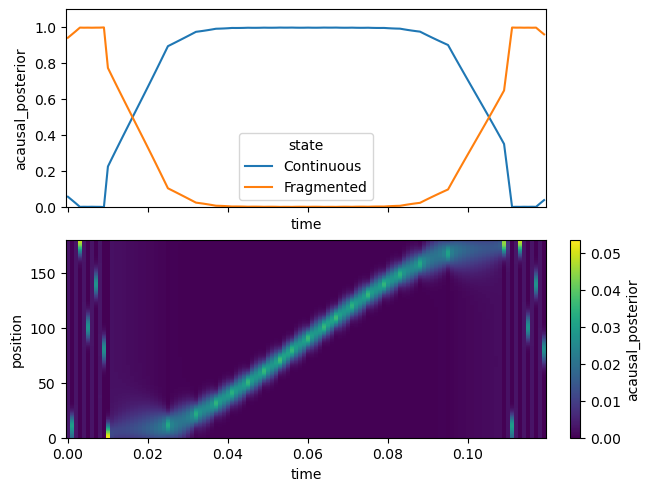

In [18]:
fig, axes = plt.subplots(2, 1, sharex=True, constrained_layout=True)
results3.acausal_posterior.unstack("state_bins").sum("position").plot(
    x="time", hue="state", ax=axes[0]
)
axes[0].set_ylim((0, 1.1))
results3.acausal_posterior.unstack("state_bins").sum("state").plot(
    x="time", y="position", ax=axes[1]
)